In [1]:
%matplotlib inline


# Multiway Cluster Robust DML

This example shows how the multiway cluster roboust DML (Chiang et al. 2020) can be implemented with the DoubleML
package.
Chiang et al. (2020) consider double-indexed data

\begin{equation}
\lbrace W_{ij}: i \in \lbrace 1, \ldots, N \rbrace, j \in \lbrace 1, \ldots, M \rbrace \rbrace
\end{equation}

and the partially linear IV regression model (PLIV)

$$\begin{aligned}
Y_{ij} = D_{ij} \theta_0 +  g_0(X_{ij}) + \epsilon_{ij}, & &\mathbb{E}(\epsilon_{ij} | X_{ij}, Z_{ij}) = 0, \\
Z_{ij} = m_0(X_{ij}) + v_{ij}, & &\mathbb{E}(v_{ij} | X_{ij}) = 0.
\end{aligned}$$

TODO: Add a few more details and the reference!
https://arxiv.org/pdf/1909.03489.pdf


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.base import clone

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from doubleml import DoubleMLData, DoubleMLPLIV
from doubleml.double_ml_resampling import DoubleMLMultiwayResampling

from doubleml.datasets import make_pliv_multiway_cluster_CKMS2019

## Simulate multiway cluster data

We use the PLIV data generating process described in Section 4.1 of Chiang et al. (2020).



In [3]:
# Set the simulation parameters
N = 25  # number of observations (first dimension)
M = 25  # number of observations (second dimension)
dim_X = 100  # dimension of X

obj_dml_data = make_pliv_multiway_cluster_CKMS2019(N, M, dim_X)

In [4]:
# The data comes with multi index for rows (tuples with two entries)
obj_dml_data.data.head(30)

X1        X2        X3        X4        X5        X6        X7  \
0 0  -0.037269 -1.174876 -0.813388 -1.846553 -1.278036  0.655020 -0.082234   
  1   0.090440 -0.367854  0.178704 -0.647542 -0.624725 -0.088348 -0.096161   
  2  -0.397812 -0.905289 -0.752149 -0.489203 -0.050432  0.405021  0.090998   
  3  -0.327063  0.097064 -0.402802 -0.604516  0.226045  0.571440  0.517467   
  4   0.297687 -0.661199 -0.667192 -0.227997 -1.501397  0.189888 -0.115934   
  5   0.016207 -0.829521 -0.966493  0.266870  0.127098  1.116569  0.213575   
  6  -0.605470 -0.990464 -1.294794 -0.822801  0.600369  1.401231  1.272837   
  7   0.657508 -0.495728  0.672462 -0.120879 -0.935806 -0.756841  0.770741   
  8   0.072866 -0.808052  0.320918  0.552200  0.000401 -0.015733  0.008178   
  9  -0.389465  0.096607 -0.528727 -0.414275  0.729180  0.889523  0.136503   
  10 -0.225965 -0.276969 -0.694716  0.173598  0.302847  0.905522  0.810208   
  11 -0.177484  0.395034  0.122062 -0.028590  0.166313  0.488961  0.367050   
  12 -0.241586 -0.076157  0.247210  0.262689 -0.121677  0.718820  1.202118   
  13  0.576678  0.261363 -0.100059 -0.606712 -0.175699  0.247535 -1.524924   
  14 -0.730933 -0.536918 -0.984494  0.206098  0.018400  0.614644  0.018081   
  15  0.916865 -0.282824 -0.389672 -0.573976 -0.423660  0.418951 -0.302483   
  16 -0.324232  0.039227 -1.023176 -1.117191  0.716450  0.420208 -0.497873   
  17  0.156282 -1.121496 -1.165785 -0.614746  0.024494  0.968934  0.214564   
  18 -0.501034 -0.629724 -0.161078 -1.254332  0.346448  1.391420  0.412150   
  19 -1.540851 -0.390108 -0.337327 -1.181196  0.139151  1.539303  0.388078   
  20  0.171862  0.178283 -0.537903 -0.272281 -0.799235  0.420253 -0.497927   
  21  0.538085 -0.186808  0.570412  0.277704 -0.143182  0.463213  1.081491   
  22 -0.623839 -0.441187  0.047298 -0.894808  0.255394  1.887009  0.336181   
  23 -0.296205 -0.605689 -1.159784 -0.014867 -0.173715  0.903678  0.804772   
  24 -0.162335  0.302506 -1.328196  0.322535 -0.600771 -0.330492 -0.313861   
1 0   0.769549  0.324432  0.220934 -0.404810 -0.956849  1.020120 -0.220663   
  1  -1.064592 -0.560668 -0.909719 -0.650582  0.555927  0.566008 -0.554924   
  2  -0.006177 -0.259866 -0.068143 -0.865824 -0.963940 -0.013944 -0.875664   
  3  -0.190537  0.381897  0.639369  1.179448  0.814435  0.188239  0.193710   
  4  -0.115112  1.081893  0.510064 -0.148149  0.223280  1.192425  0.092083   

            X8        X9       X10  ...       X94       X95       X96  \
0 0  -0.202079  0.374079 -0.328329  ...  0.505869  0.530996 -0.585672   
  1   0.709039 -0.129109  0.097299  ...  0.495700  0.510396 -0.524375   
  2  -1.027483  0.268759  0.056208  ...  0.472686  0.856724 -0.528895   
  3   0.334907 -0.619371 -0.684774  ... -0.527840 -1.000261  0.559514   
  4  -0.361469 -0.303685 -1.070821  ...  0.082693 -0.332864 -0.646533   
  5   1.312192 -0.533870 -0.992011  ...  0.990327  0.622728  0.224596   
  6  -0.203270  0.414073 -0.510083  ...  0.418852  0.038103 -0.636507   
  7   1.134504  0.539358  0.262856  ...  0.217862  0.443935  0.889754   
  8   0.507637 -0.133493 -0.148477  ... -0.090607  0.085883 -0.215496   
  9   0.366877 -0.786550  0.045539  ...  0.341343 -0.720278 -0.027994   
  10  0.187316  0.717024 -0.118598  ...  0.835681 -0.019008 -0.777574   
  11  0.351160 -0.826193  0.270996  ...  0.004331  0.284186  0.837806   
  12 -0.359126 -0.783003 -0.167765  ...  0.198730 -0.662029 -0.759414   
  13 -1.615121 -0.829194 -1.134952  ... -0.481216 -1.260158  0.144558   
  14 -0.494751  0.300214  0.745807  ... -0.734337  0.218051 -0.124795   
  15  0.374462 -0.723817 -0.090122  ... -0.728036 -0.004506 -0.111586   
  16 -0.422475 -0.061495  0.109050  ...  0.263521 -0.296692 -0.564665   
  17 -0.083531 -0.020214  0.108036  ... -0.274825  0.160000  0.173356   
  18 -0.009334  0.002343  0.036431  ... -0.071474  0.251166  0.344318   
  19  0.415133 -0.837119 -0.878090  ...  0.203970  0.585586  0.027839   
  20  0.246913  0.194313  0.240903  ... -0.972212  0.443497 

## Initialize the objects of class DoubleMLData and DoubleMLPLIV



In [5]:
# Set machine learning methods for m & g
learner = RandomForestRegressor(max_depth=2, n_estimators=10)
ml_g = clone(learner)
ml_m = clone(learner)
ml_r = clone(learner)

# initialize the DoubleMLPLIV object
dml_pliv_obj = DoubleMLPLIV(obj_dml_data,
                            ml_g,
                            ml_m,
                            ml_r,
                            score='partialling out',
                            dml_procedure='dml1',
                            draw_sample_splitting=False)

## Split samples and transfer the sample splitting to the object



In [6]:
K = 3  # number of folds
smpl_sizes = [N, M]
obj_dml_multiway_resampling = DoubleMLMultiwayResampling(K, smpl_sizes)
smpls_multi_ind, smpls_lin_ind = obj_dml_multiway_resampling.split_samples()

dml_pliv_obj.set_sample_splitting([smpls_lin_ind])

## Fit the model and show a summary



In [7]:
dml_pliv_obj.fit()
print(dml_pliv_obj.summary)

       coef   std err          t          P>|t|     2.5 %   97.5 %
D  1.062763  0.043403  24.486052  2.079876e-132  0.977695  1.14783


## Visualization of sample splitting with tuple and linear indexing



In [8]:
#discrete color scheme
x = sns.color_palette("RdBu_r", 7)
cMap = ListedColormap([x[0], x[3], x[6]])
plt.rcParams['figure.figsize'] = 15, 12
sns.set(font_scale=1.3)

### Visualize sample splitting with tuples (one plot per fold)



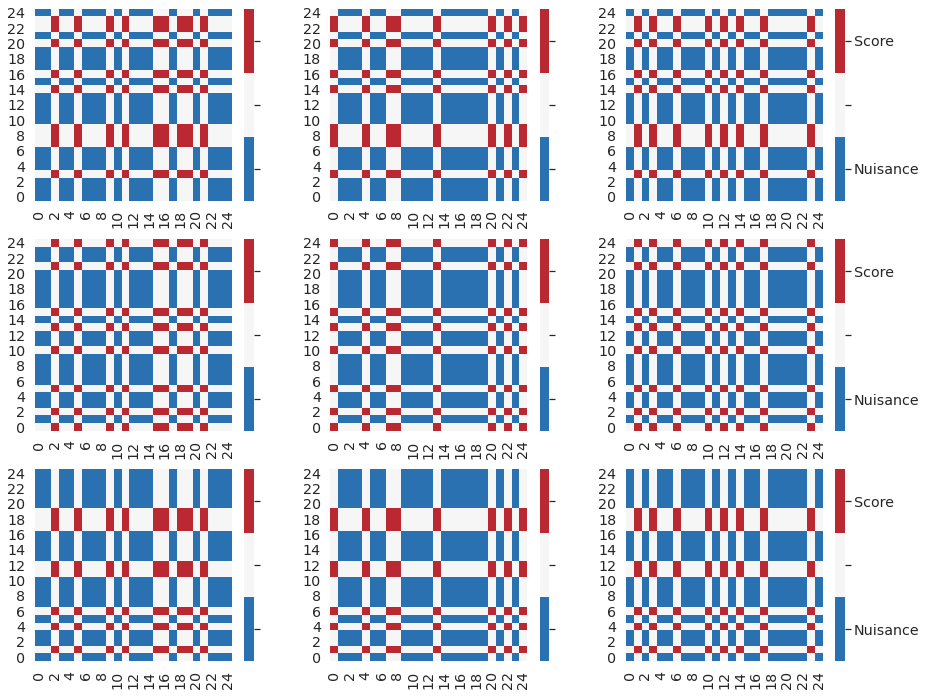

In [9]:
for i_split, this_split_ind in enumerate(smpls_multi_ind):
    plt.subplot(K, K, i_split + 1)
    df = pd.DataFrame(np.zeros([N, M]))
    ind_array_train = np.array([*this_split_ind[0]])
    ind_array_test = np.array([*this_split_ind[1]])
    df.loc[ind_array_train[:, 0], ind_array_train[:, 1]] = -1.
    df.loc[ind_array_test[:, 0], ind_array_test[:, 1]] = 1.

    ax = sns.heatmap(df, cmap=cMap);
    ax.invert_yaxis();
    ax.set_ylim([0, M]);
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([-0.667, 0, 0.667])
    if i_split % K == (K - 1):
        colorbar.set_ticklabels(['Nuisance', '', 'Score'])
    else:
        colorbar.set_ticklabels(['', '', ''])

### Visualize sample splitting with linear indexing (one column per fold)



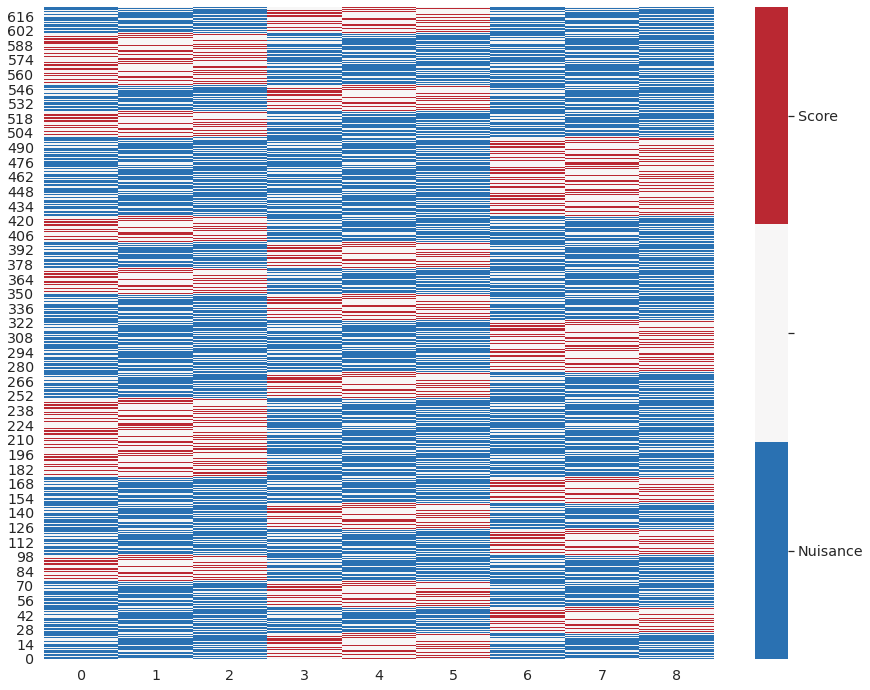

In [10]:
df = pd.DataFrame(np.zeros([N*M, K*K]))
for i_split, this_split_ind in enumerate(smpls_lin_ind):
    df.loc[this_split_ind[0], i_split] = -1.
    df.loc[this_split_ind[1], i_split] = 1.

ax = sns.heatmap(df, cmap=cMap);
ax.invert_yaxis();
ax.set_ylim([0, N*M]);
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([-0.667, 0, 0.667])
colorbar.set_ticklabels(['Nuisance', '', 'Score'])